In [2]:
i_weight = np.random.rand(1,2)
h_weight = np.random.rand(2,2)
o_weight = np.random.rand(2,1)
i_weight

array([[0.5488135 , 0.71518937]])

In [3]:
data = pd.read_csv("./zero_to_gpt/data/clean_weather.csv", index_col=0)
# data
# index = data.isnull().any(axis=1)
# nan_rows = data[data.isnull().any(axis=1)].index
# for idx in nan_rows:
#     if data.index.get_loc(idx) > 0:
#         row = data.iloc[data.index.get_loc(idx) - 1]
                
#         print(row.name, '\t', '\t'.join([f"{v}" for v in row.values]))
# print(data[index])
data = data.ffill()
# data[data.isna().any(axis=1)]
# print(data[index])

In [4]:
data = data.ffill()
temps = data["tmax"].tail(3).to_numpy()
X = temps
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

In [5]:
x0

array([[66.]])

In [6]:
xi_0 = x0 @ i_weight
xh_0 = np.maximum(0, xi_0)
xo_0 = xh_0 @ o_weight
xo_0

array([[57.94406231]])

In [7]:
xi_1 = x1 @ i_weight
xh = xh_0 @ h_weight + xi_1
xh_1 = np.maximum(0, xh)
xo_1 = xh_1 @ o_weight
xo_1

array([[124.54916092]])

In [8]:
xi_2 = x2 @ i_weight
xh = xh_1 @ h_weight + xi_2
xh_2 = np.maximum(xh, 0)
xo_2 = xh_2 @ o_weight
xo_2

array([[190.94853131]])

**tanh**
$$ \tanh = \dfrac{e^x - e^{-x}}{e^x + e^{-x}} $$

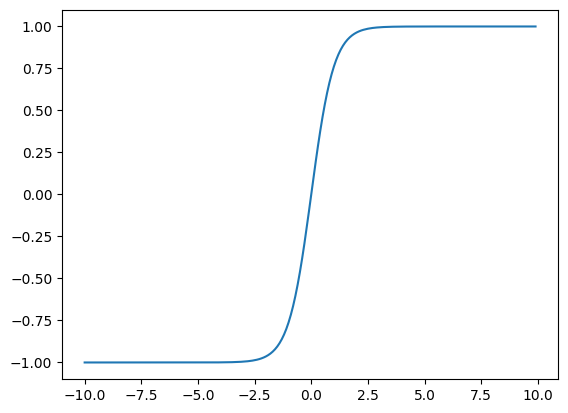

In [9]:
import  matplotlib.pyplot as plt
temps = np.arange(-10,10,.1)
plt.plot(temps, np.tanh(temps))

In [10]:
from sympy import diff, symbols, exp, simplify
x = symbols('x')
tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
diff(tanh, x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

In [11]:
sig = 1 / (1 + exp(-x))
diff(sig, x)

exp(-x)/(1 + exp(-x))**2

In [12]:
from numpy.typing import NDArray as Array
np.random.seed(0)
wi: Array[np.float64] = np.random.rand(1, 5)/5 - .1
wh: Array[np.float64] = np.random.rand(5,5)/5 - .1
bh: Array[np.float64] = np.random.rand(1,5)/5 - .1
wo: Array[np.float64] = np.random.rand(5,1) * 50
bo: Array[np.float64] = np.random.rand(1,1)

h: Array[np.float64] = np.zeros((5,1))
pre_h: Array[np.float64] = np.zeros((1, 5))
temps: Array[np.float64] = data["tmax"].tail(3).to_numpy()

print(temps)
outputs: list[Array[np.float64]] = np.zeros(3)
hiddens = np.zeros((3,5))

for val, i in zip(temps, range(3)):
    val = val.reshape(1,1)
    xi: Array[np.float64] = val @ wi
    h = np.tanh((pre_h @ wh) + bh + xi)
    pre_h = h
    hiddens[i,:] = h
    outputs[i] = h @ wo + bo
    
print(outputs)

[66. 70. 62.]
[72.45624142 80.54746173 77.67192111]


/var/folders/f7/chy8r0p10x14zsxsjfxjmnx80000gn/T/ipykernel_42674/485245560.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i] = h @ wo + bo


In [13]:
def mse(act, pre):
    return ((act - pre) ** 2).mean()



def mse_grad(act, pre):
    return (pre - act)


loss_grad = mse_grad(temps, outputs)
loss_grad

array([ 6.45624142, 10.54746173, 15.67192111])

In [14]:
wo_grad, bo_grad, wh_grad, bh_grad, wi_grad = [0] * 5
next_h_grad  = None

for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1,1)
    wo_grad += hiddens[i, :][:, np.newaxis] @ l_grad
    bo_grad += np.mean(l_grad)
    o_grad = l_grad @ wo.T
    print(o_grad)
    if next_h_grad is not None:
        h_grad = o_grad + next_h_grad @ wh.T
    else:
        h_grad = o_grad
    
    tanh_derivate = 1 - hiddens[i, :][np.newaxis, :] ** 2
    tanh_grad = np.multiply(h_grad, tanh_derivate)
    next_h_grad = tanh_grad

    if i>0:
        wh_grad += hiddens[i-1, ][:, np.newaxis] @ h_grad
        bh_grad += np.mean(h_grad, axis=0)

    print(X[i])
    print(h_grad)
    wi_grad += X[i].reshape(1, -1).T @ h_grad
    
print(wi_grad)


[[483.97673924 479.6357939  483.42704645 739.5172717  534.27169693]]
62.0
[[483.97673924 479.6357939  483.42704645 739.5172717  534.27169693]]
[[325.72433844 322.80281054 325.35438611 497.70733707 359.57367559]]
70.0
[[379.58927092 363.94395175 341.48587052 539.18229052 378.22479435]]
[[199.38019387 197.59188784 199.15374114 304.65327163 220.09982273]]
66.0
[[235.25678465 227.55673324 206.32644935 335.64788102 232.04529699]]
[[ 72104.75458431  70232.24023799  67494.03347341 105745.59132839
   74915.57041518]]


In [15]:
lr = 1e-8
# We'll divide the learning rate by the sequence length, since we were adding together the gradients
# This makes training the model more stable
lr = lr / 3

wi -= wi_grad * lr
wh -= wh_grad * lr
bh -= bh_grad * lr
wo -= wo_grad * lr
bo -= bo_grad * lr

In [16]:
pre_h = np.zeros((1, 5))
for val, i in zip(temps, range(3)):
    val = val.reshape(1,1)
    xi: Array[np.float64] = val @ wi
    h = np.tanh((pre_h @ wh) + bh + xi)
    pre_h = h
    hiddens[i,:] = h
    outputs[i] = h @ wo + bo
print(outputs)

[71.003952   79.2225618  76.35726338]


/var/folders/f7/chy8r0p10x14zsxsjfxjmnx80000gn/T/ipykernel_42674/3200063850.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i] = h @ wo + bo


In [17]:
def mse(act, pre):
    return ((act - pre) ** 2).mean()


def mse_grad(act, pre):
    return (pre - act)

print(temps)
print(outputs)
loss_grad = mse_grad(temps, outputs)
loss_grad

[66. 70. 62.]
[71.003952   79.2225618  76.35726338]


array([ 5.003952  ,  9.2225618 , 14.35726338])

In [18]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        layer = layer_conf[i]
        k = 1/np.sqrt(layer_conf[i]["hidden"])
        print(layer_conf[i-1]["units"])
        print(layer["hidden"])
        wi = np.random.rand(layer_conf[i-1]["units"], layer["hidden"]) * 2 * k - k
        
        bh = np.random.rand(1, layer["hidden"]) * 2 * k - k
        wh = np.random.rand(layer["hidden"], layer["hidden"]) * 2 * k - k
        
        wo = np.random.rand(layer["hidden"], layer["output"]) * 2 * k - k
        bo = np.random.rand(1, layer["output"]) * 2 * k - k
        
        layers.append([wi, wh, bh, wo, bo])
    return layers

In [19]:
from sklearn.preprocessing import StandardScaler
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])
np.random.seed(0)
split_data = np.split(data, [int(len(data)*.7), int(len(data)*.9)])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[TARGET].to_numpy()] for d in split_data]
train_y[1:(1+7),]

/Users/zhengjiayi/anaconda3/envs/DSA/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


array([52., 53., 52., 50., 52., 56., 54.])

In [20]:
from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

/Users/zhengjiayi/anaconda3/envs/DSA/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [21]:
train_x

array([[-0.72725587, -2.27150212, -0.25366126],
       [-1.68779357, -1.6825982 , -0.25366126],
       [-1.68779357, -2.27150212, -0.25366126],
       ...,
       [ 0.47341624,  1.70359934, -0.25366126],
       [ 0.23328182,  1.2619214 , -0.25366126],
       [ 1.31388673,  1.2619214 , -0.25366126]], shape=(9456, 3))

In [22]:
layer_conf = [
    {
        "type": "input",
        "units": 3,
    },
    {
        "type": "rnn",
        "hidden": 4,
        "output": 1,
    }
]
layers = init_params(layer_conf)

3
4


In [23]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        wi, wh, bh, wo, bo = layers[i]
        hidden = np.zeros((x.shape[0], wi.shape[1]))
        output = np.zeros((x.shape[0], wo.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,][np.newaxis,:] @ wi
            hidden_x = input_x + hidden[max(j-1, 0),][np.newaxis,:] @ wh + bh
            hidden_x = np.tanh(hidden_x)
            hidden[j,:] = hidden_x
            
            output_x = hidden_x @ wo + bo   
            # input()
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

        

In [24]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        wi, wh, bh, wo, bo = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        wi_grad, wh_grad, bh_grad, wo_grad, bo_grad = [0] * 5
        for j in range(x.shape[0]-1, -1, -1):
            l_grad = grad[j,:][np.newaxis, :]
            o_grad = l_grad @ wo.T
            wo_grad += hidden[j,:][:, np.newaxis] @ l_grad
            bo_grad += l_grad
            
            h_grad = o_grad @ wh.T
            if j < x.shape[0] - 1:
                h_grad += next_h_grad @ wh.T
            
            tanh_deriv = 1 - hidden[j,:][np.newaxis, :]**2
            h_grad = np.multiply(h_grad, tanh_deriv)
            next_h_grad = h_grad.copy()
            if j>0:
                wh_grad += hidden[j-1][:, np.newaxis] @ h_grad
                bh_grad += h_grad
            
            wi_grad += x[j,][:, np.newaxis] @ h_grad
        
        lr = lr/x.shape[0]
        wi -= lr * wi_grad
        wh -= lr * wh_grad
        bh -= lr * bh_grad
        wo -= lr * wo_grad
        bo -= lr * bo_grad
        layers[i] = [wi, wh, bh, wo, bo]
    return layers
    

In [25]:
epochs = 500
lr = 1e-6

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0]-sequence_len):
        x = train_x[j:(j+sequence_len),]
        y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(x, layers)
        grad = mse_grad(y, outputs)
        params = backward(layers,x,lr, grad, hiddens)
        epoch_loss += mse(y, outputs)
    
    if (epoch+1) %10 == 0:
        for j in range(valid_x.shape[0]-sequence_len):
            x = valid_x[j:(j+sequence_len),]
            y = valid_y[j:(j+sequence_len),]
            hiddens, outputs = forward(x, layers)
            epoch_loss += mse(y, outputs)
        print(f"Epoch {epoch+1} loss: {epoch_loss/(valid_x.shape[0]-sequence_len)}")
            

Epoch 10 loss: 15502.501572524798
Epoch 20 loss: 6701.117446770488
Epoch 30 loss: 2949.1576800743123
Epoch 40 loss: 1435.3348014373503
Epoch 50 loss: 823.35378758742
Epoch 60 loss: 574.3261250716541
Epoch 70 loss: 472.1038771213111
Epoch 80 loss: 429.8968454952332
Epoch 90 loss: 412.6900730686891
Epoch 100 loss: 406.2754197044231
Epoch 110 loss: 404.89019589314785
Epoch 120 loss: 406.27055258257553


KeyboardInterrupt: 